# Domain 1: Crowdsourcing to Support Education Needs

# Predicting projects that are unlikely to be funded without expert assistance to prioritize resources for DonorsChoose

## This notebook contains Classification Task Models for predicting T/F- whether or not a project will be funded at the time of its posting date

### Arthur Spirou (aspirou), Akin Joseph (ababujos), & Nikki Chen (yiqichen)
Machine Learning Foundations with Python

Due: May 1, 2025

### Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from IPython.display import display
from sklearn.feature_selection import VarianceThreshold

In [3]:
#from google.colab import drive

In [5]:
#drive.mount('/content/drive')

In [7]:
# Colab read example
#df = pd.read_csv('/content/drive/My Drive/ML Project/TIDY_unclean.csv')

In [9]:
warnings.filterwarnings('ignore')

### Read in the Data

In [15]:
df = pd.read_csv('TIDY.csv')

In [17]:
# Save an original copy of the data for sanity
data = df.copy()

In [19]:
# Uncomment the line below to see the full list of columns
#print(df.columns.tolist())

### Remove the year 2014 as we do not have labels for these projects, then select desired features to include

In [22]:
df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')

# Filter out any rows posted in 2014 or later
df = df[df['date_posted'] < pd.Timestamp('2014-01-01')]

# Define columns to keep
selected_columns = [
    'school_state', 
    'school_charter',
    'school_magnet',
    'school_kipp',
    'school_charter_ready_promise',
    'school_nlns',
    'teacher_teach_for_america',
    'teacher_ny_teaching_fellow',
    'total_price_including_optional_support',
    'primary_focus_subject',
    'resource_type',
    'poverty_level',
    'grade_level',
    'eligible_double_your_impact_match',
    'eligible_almost_home_match',
    'fully_funded',           # label (gets remapped below so that fully_funded = 1 means a project was not funded and fully_funded = 0 means it was funded)
    'projectid',              # keep for row ID reference (not ML input) ***Rows are defined by unique projectid + date_posted combinations***
    'date_posted',            # keep for date-based split (not ML input)
    'sp500_avg_30d',
    'sp500_std_30d',
    'essay_length',
    'total_item_quantity',
    'num_items',
    'total_item_cost',
    'need_statement_length',
    'teacher_prefix',
    'state_gdp',
    'month_of_year',
    'day_of_week'
]

df_filtered = df[selected_columns]

print(f"Filtered data shape: {df_filtered.shape}")
df_filtered.head()

Filtered data shape: (619326, 29)


,school_state,school_charter,school_magnet,school_kipp,school_charter_ready_promise,school_nlns,teacher_teach_for_america,teacher_ny_teaching_fellow,total_price_including_optional_support,primary_focus_subject,...,sp500_std_30d,essay_length,total_item_quantity,num_items,total_item_cost,need_statement_length,teacher_prefix,state_gdp,month_of_year,day_of_week
0,NY,f,t,f,f,f,f,f,279.27,Other,...,30.096573,1254.0,0.0,0.0,0.0,75.0,Mr.,876285.2,9,4
1,NY,f,f,f,f,f,f,f,152.44,Literacy,...,30.096573,2272.0,0.0,0.0,0.0,75.0,Ms.,876285.2,9,4
2,NY,f,t,f,f,f,f,f,152.44,Early Development,...,29.139639,1239.0,0.0,0.0,0.0,75.0,Ms.,876285.2,9,0
3,NY,f,f,f,f,f,f,f,998.78,Other,...,26.470111,1825.0,0.0,0.0,0.0,75.0,Ms.,876285.2,9,1
4,NY,f,f,f,f,f,f,f,1376.83,Economics,...,26.470111,2271.0,0.0,0.0,0.0,263.0,Mr.,876285.2,9,1


### Missing Values/Outliers Check, Print outlier summary but don't treat until after train/test split
Note: Some previous cleaning has already been done on this data but not on all possible features

In [25]:
# Columns to check for outliers
numeric_cols = [
    'total_price_including_optional_support',
    'sp500_avg_30d',
    'sp500_std_30d',
    'essay_length',
    'total_item_quantity',
    'num_items',
    'total_item_cost',
    'need_statement_length',
    'state_gdp'
]

# NaN summary
nan_summary = df_filtered.isna().sum().to_frame(name='missing_count')
nan_summary['missing_pct'] = (nan_summary['missing_count'] / len(df_filtered)) * 100

# Outlier summary for the two price columns
outlier_summary = pd.DataFrame(columns=['lower_bound', 'upper_bound', 'outlier_count', 'outlier_pct'])

for col in numeric_cols:
    lower = df_filtered[col].quantile(0.01)
    upper = df_filtered[col].quantile(0.99)
    outlier_mask = (df_filtered[col] < lower) | (df_filtered[col] > upper)
    outlier_count = outlier_mask.sum()
    outlier_pct = outlier_count / len(df_filtered) * 100

    outlier_summary.loc[col] = [lower, upper, outlier_count, outlier_pct]

# Combine both summaries
summary_report = nan_summary.copy()
summary_report[['lower_bound', 'upper_bound', 'outlier_count', 'outlier_pct']] = outlier_summary

# Show full report
summary_report.fillna('', inplace=True)
summary_report

,missing_count,missing_pct,lower_bound,upper_bound,outlier_count,outlier_pct
school_state,0,0.000000,,,,
school_charter,0,0.000000,,,,
school_magnet,0,0.000000,,,,
school_kipp,0,0.000000,,,,
school_charter_ready_promise,0,0.000000,,,,
school_nlns,0,0.000000,,,,
teacher_teach_for_america,0,0.000000,,,,
teacher_ny_teaching_fellow,0,0.000000,,,,
total_price_including_optional_support,0,0.000000,147.56,2822.635,12344.0,1.993134
primary_focus_subject,36,0.005813,,,,


In [27]:
# drop missing values
print('Shape BEFORE dropping missing values:', df_filtered.shape)
df_cleaned = df_filtered.dropna().copy()
print('Shape AFTER dropping missing values:', df_cleaned.shape)

# Convert t/f → 1/0 for standard binary columns
binary_cols = [
    'school_charter',
    'eligible_double_your_impact_match',
    'eligible_almost_home_match',
    'school_magnet',
    'school_kipp',
    'school_charter_ready_promise',
    'school_nlns',
    'teacher_teach_for_america',
    'teacher_ny_teaching_fellow'
]

for col in binary_cols:
    df_cleaned[col] = df_cleaned[col].map({'t': 1, 'f': 0})

# Convert t/f → 0/1 for the label (fully_funded: 't' means funded → now label 0)
df_cleaned['fully_funded'] = df_cleaned['fully_funded'].map({'t': 0, 'f': 1})

df_cleaned.head()

Shape BEFORE dropping missing values: (619326, 29)
Shape AFTER dropping missing values: (617786, 29)


,school_state,school_charter,school_magnet,school_kipp,school_charter_ready_promise,school_nlns,teacher_teach_for_america,teacher_ny_teaching_fellow,total_price_including_optional_support,primary_focus_subject,...,sp500_std_30d,essay_length,total_item_quantity,num_items,total_item_cost,need_statement_length,teacher_prefix,state_gdp,month_of_year,day_of_week
0,NY,0,1,0,0,0,0,0,279.27,Other,...,30.096573,1254.0,0.0,0.0,0.0,75.0,Mr.,876285.2,9,4
1,NY,0,0,0,0,0,0,0,152.44,Literacy,...,30.096573,2272.0,0.0,0.0,0.0,75.0,Ms.,876285.2,9,4
2,NY,0,1,0,0,0,0,0,152.44,Early Development,...,29.139639,1239.0,0.0,0.0,0.0,75.0,Ms.,876285.2,9,0
3,NY,0,0,0,0,0,0,0,998.78,Other,...,26.470111,1825.0,0.0,0.0,0.0,75.0,Ms.,876285.2,9,1
4,NY,0,0,0,0,0,0,0,1376.83,Economics,...,26.470111,2271.0,0.0,0.0,0.0,263.0,Mr.,876285.2,9,1


In [29]:
# Reprint full missing values summary for peace of mind
print("Any missing values left?", df_cleaned.isna().any().any())
print("Total missing values:", df_cleaned.isna().sum().sum())

Any missing values left? False
Total missing values: 0


In [31]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 617786 entries, 0 to 619325
Data columns (total 29 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   school_state                            617786 non-null  object        
 1   school_charter                          617786 non-null  int64         
 2   school_magnet                           617786 non-null  int64         
 3   school_kipp                             617786 non-null  int64         
 4   school_charter_ready_promise            617786 non-null  int64         
 5   school_nlns                             617786 non-null  int64         
 6   teacher_teach_for_america               617786 non-null  int64         
 7   teacher_ny_teaching_fellow              617786 non-null  int64         
 8   total_price_including_optional_support  617786 non-null  float64       
 9   primary_focus_subject                   61

In [33]:
df_merged = df_cleaned.copy()

In [35]:
# Sanity check on the start and end dates of the data prior to proceeding with train/test splits
print(df_merged['date_posted'].min(), '\n', df_merged['date_posted'].max())

2002-09-13 00:00:00 
 2013-12-31 00:00:00


In [37]:
# transform the binary columns to bool prior to encoding because they are currently ints
for col in binary_cols:
    df_merged[col] = df_merged[col].astype('bool')

In [39]:
# transform day of week and month of year int categories into objects for one-hot encoding
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

df_merged['day_of_week'] = df_merged['day_of_week'].map(dict(zip(range(7), days))).astype('category')
df_merged['month_of_year'] = df_merged['month_of_year'].map(dict(zip(range(1, 13), months))).astype('category')

In [41]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 617786 entries, 0 to 619325
Data columns (total 29 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   school_state                            617786 non-null  object        
 1   school_charter                          617786 non-null  bool          
 2   school_magnet                           617786 non-null  bool          
 3   school_kipp                             617786 non-null  bool          
 4   school_charter_ready_promise            617786 non-null  bool          
 5   school_nlns                             617786 non-null  bool          
 6   teacher_teach_for_america               617786 non-null  bool          
 7   teacher_ny_teaching_fellow              617786 non-null  bool          
 8   total_price_including_optional_support  617786 non-null  float64       
 9   primary_focus_subject                   61

### Create Masks and Conduct earliest 80%/latest 20% Train/Test Split based on data sorted by project posting date

In [44]:
# Ensure datetime format
df_merged['date_posted'] = pd.to_datetime(df_merged['date_posted'], errors='coerce')

# Sort by time
df_sorted = df_merged.sort_values('date_posted')

# Get 80% split index
split_index = int(0.8 * len(df_sorted))

# Get the cutoff date at that index
cutoff_date = df_sorted.iloc[split_index]['date_posted']

# Create masks using cutoff_date
train_mask = df_merged['date_posted'] < cutoff_date
test_mask = ~train_mask

print("Cutoff date for 80/20 split:", cutoff_date)

# Set up feature and target columns
df_model = df_merged.copy()
target_col = 'fully_funded'

columns_to_drop = ['projectid', 'date_posted', 'fully_funded', 'year_posted']
feature_cols = [col for col in df_model.columns if col not in columns_to_drop]

# Apply masks to split data
X_train = df_model.loc[train_mask, feature_cols]
y_train = df_model.loc[train_mask, target_col]

X_test = df_model.loc[test_mask, feature_cols]
y_test = df_model.loc[test_mask, target_col]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Target distribution in train:\n{y_train.value_counts(normalize=True)}")

Cutoff date for 80/20 split: 2013-01-29 00:00:00
Train shape: (493988, 26), Test shape: (123798, 26)
Target distribution in train:
fully_funded
0    0.693456
1    0.306544
Name: proportion, dtype: float64


In [46]:
# Uncomment below line for another sanity check summary after doing the train/test splits
#print(X_train.info(), '\n', '\n', y_train.info(), '\n', '\n', X_test.info(), '\n', '\n', y_test.info())

### Now, treat outliers on the train set only (to avoid data leakage)

In [49]:
# cap outliers using the IQR method
def handle_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        if col == 'state_gdp':
            continue # don't cap outliers for state_gdp
        if df_clean[col].dtype in ['int64', 'float64']:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
            print(f"Column {col}: {outliers} outliers capped")

            df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)
    return df_clean

# Apply the capping to numeric columns
X_train = handle_outliers(X_train, numeric_cols)

Column total_price_including_optional_support: 21995 outliers capped
Column sp500_avg_30d: 0 outliers capped
Column sp500_std_30d: 35615 outliers capped
Column essay_length: 3572 outliers capped
Column total_item_quantity: 39259 outliers capped
Column num_items: 46376 outliers capped
Column total_item_cost: 19089 outliers capped
Column need_statement_length: 30744 outliers capped


### Conduct variance thresholding to drop unhelpful columns from test set

Drops columns with little variance from test set (meeans they have little predictive power and just clutter the model)

In [52]:
# Recompute numeric columns after outlier handling
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Apply VarianceThreshold to numeric features only
var_thresh = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
X_train_numeric = var_thresh.fit_transform(X_train[numeric_cols])

# Get columns to keep and drop
kept_numeric_cols = X_train[numeric_cols].columns[var_thresh.get_support()].tolist()
dropped_numeric_cols = list(set(numeric_cols) - set(kept_numeric_cols))

print(f"Removed {len(dropped_numeric_cols)} low-variance numeric features:")
for col in sorted(dropped_numeric_cols):
    print(f" - {col}")

# Rebuild X_train: high-variance numeric features + all other columns
X_train = pd.concat([
    pd.DataFrame(X_train_numeric, columns=kept_numeric_cols, index=X_train.index),
    X_train.drop(columns=numeric_cols)  # drop all numeric, then re-add filtered
], axis=1)

Removed 0 low-variance numeric features:


### Correlation Filter on test set to compliment the above variance filter

Finds pairs of features which are highly correlated to each other and drops one from the pair- this helps to reduce overfitting

In [55]:
# Only look at numeric features again (post-variance filter)
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr_matrix = X_train[numeric_cols].corr().abs()

# Create upper triangle mask
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Set correlation threshold — common value: 0.9
corr_threshold = 0.9

# Find columns with high correlation to others
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > corr_threshold)]

# Drop from X_train
X_train = X_train.drop(columns=to_drop)

print(f"\nRemoved {len(to_drop)} highly correlated numeric features (threshold > {corr_threshold}):")
for col in sorted(to_drop):
    print(f" - {col}")


Removed 1 highly correlated numeric features (threshold > 0.9):
 - total_item_cost


### Create Column Transformer for automated feature encoding

In [69]:
# Identify feature types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
bool_features = X_train.select_dtypes(include=['bool']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features += bool_features  # treat bools as categoricals

# Separate out ordinal features
ordinal_features = ['grade_level', 'poverty_level']
categorical_features = [col for col in categorical_features if col not in ordinal_features]

# Define the correct order for ordinal features
grade_order = ['Grades PreK-2', 'Grades 3-5', 'Grades 6-8', 'Grades 9-12']
poverty_order = ['low poverty', 'moderate poverty', 'high poverty', 'highest poverty'] # ensure highest level of need gets largest encoded value

# Set up ColumnTransformer with correct encoders
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('ord', OrdinalEncoder(categories=[grade_order, poverty_order]), ordinal_features)
])

# Print for verification
print("Numeric:", numeric_features, '\n')
print("Categorical (OneHot):", categorical_features, '\n')
print("Ordinal:", ordinal_features)

Numeric: ['total_price_including_optional_support', 'sp500_avg_30d', 'sp500_std_30d', 'essay_length', 'total_item_quantity', 'num_items', 'need_statement_length', 'state_gdp'] 

Categorical (OneHot): ['school_state', 'primary_focus_subject', 'resource_type', 'teacher_prefix', 'month_of_year', 'day_of_week', 'school_charter', 'school_magnet', 'school_kipp', 'school_charter_ready_promise', 'school_nlns', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'eligible_double_your_impact_match', 'eligible_almost_home_match'] 

Ordinal: ['grade_level', 'poverty_level']


In [60]:
# Sanity check for missing columns - prints an empty set if all is good to proceed
all_tracked_cols = set(numeric_features + categorical_features + ordinal_features)
all_X_cols = set(X_train.columns)

missing_cols = all_X_cols - all_tracked_cols

print("Unassigned columns:", missing_cols)

Unassigned columns: set()


### Establish variables for Time-Series Sliding-Window Cross-Validation (n_splits = 5)

In [63]:
# Set up time-aware cross-validation
n=5
tscv = TimeSeriesSplit(n_splits=n)

cv_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

### Create a 70%/30% Biased Coin Classifier for use as a baseline model

In [66]:
class BiasedCoinClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, random_state=42):
        self.random_state = random_state

    def fit(self, X, y):
        return self

    def predict(self, X):
        rng = np.random.RandomState(self.random_state)
        return rng.choice([0, 1], size=X.shape[0], p=[0.7, 0.3])

    def predict_proba(self, X):
        return np.tile([0.7, 0.3], (X.shape[0], 1))

### Create Dictionary of Models and Grids for Grid Search. Evaluate and select best hyperparameters based upon Precision score

Here we define Logistic Regression (3 types: ridge, lasso, and elasticnet), Decision Tree, Random Forest, XGBoost, and AdaBoost Classification models with respective hyperparameters

In [67]:
models_and_grids = {
    "Logistic Regression_Ridge": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "param_grid": {
            "model__C": [0.01, 0.1, 1, 10],
            "model__penalty": ["l2"],
            "model__solver": ["lbfgs"],
            "model__class_weight": [None, "balanced"]
        }
    },
    "Logistic Regression_Lasso": {
    "model": LogisticRegression(max_iter=1000, random_state=42),
    "param_grid": {
        "model__C": [0.01, 0.1, 1, 10],
        "model__penalty": ["l1"],
        "model__solver": ["liblinear"],
        "model__class_weight": [None, "balanced"]
        }
    },
    "Logistic Regression_ElasticNet": {
    "model": LogisticRegression(max_iter=1000, random_state=42),
    "param_grid": {
        "model__C": [0.01, 0.1, 1, 10],
        "model__penalty": ["elasticnet"],
        "model__solver": ["saga"],
        "model__l1_ratio": [0.1, 0.5, 0.9],  # controls L1 vs L2 balance
        "model__class_weight": [None, "balanced"]
        }
    },
    "Decision Tree": {
    "model": DecisionTreeClassifier(random_state=42),
    "param_grid": {
        "model__max_depth": [3, 5, 8, 12],
        "model__min_samples_split": [10, 50, 100],
        "model__min_samples_leaf": [10, 20, 50]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, n_jobs=-1),
        "param_grid": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [3, 5, 8],
            "model__min_samples_split": [10, 50, 100],
            "model__min_samples_leaf": [10, 20, 50, 100],
            "model__max_features": ["sqrt", "log2", None]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "param_grid": {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.05, 0.1, 0.3],
            "model__max_depth": [3, 5, 7],
            "model__subsample": [0.8, 1.0],
            "model__colsample_bytree": [0.8, 1.0]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "param_grid": {
            "model__n_estimators": [50, 100, 200],
            "model__learning_rate": [0.1, 0.5, 1.0],
            "model__estimator": [
                DecisionTreeClassifier(max_depth=1),
                DecisionTreeClassifier(max_depth=2)
            ]
        }
    }
}

# define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Run grid search for each model
for name, config in models_and_grids.items():
    print(f"\nRunning Grid Search for: {name}")

    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('model', config['model'])
    ])

    grid = GridSearchCV(
        pipe,
        param_grid=config['param_grid'],
        cv=tscv,
        scoring=scoring,
        refit='precision', # indicates precision is the priority metric when ranking hyperparameter combinations
        n_jobs=-1,
        return_train_score=True
    )

    # fit grid to train set
    grid.fit(X_train, y_train)

    # print best combination for maximizing precision
    print(f"Best precision parameters for {name}: {grid.best_params_}")
    print(f"Best CV Precision Score: {grid.best_score_:.4f}")


Running Grid Search for: Logistic Regression_Ridge
Best precision parameters for Logistic Regression_Ridge: {'model__C': 0.01, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV Precision Score: 0.4613

Running Grid Search for: Logistic Regression_Lasso
Best precision parameters for Logistic Regression_Lasso: {'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best CV Precision Score: 0.4562

Running Grid Search for: Logistic Regression_ElasticNet


KeyboardInterrupt: 

### Plug Optimal Hyperparameters from Grid Search into final models. Then run cross validation and/or test on final holdout set and report metrics

In [66]:
# Run the gridsearch block above this one first to get the best hyperparameters for each model then plug in and cross-validate
# The last two "coin flip" models are "dummy" baseline models for use-case comparisons
models = {
    "Logistic Regression (Ridge)": LogisticRegression(C=10, class_weight='balanced', penalty='l2', solver='lbfgs', random_state=42),
    "Logistic Regression (Lasso)": LogisticRegression(C=0.1, class_weight='balanced', penalty='l1', solver='liblinear', random_state=42),
    "Logistic Regression (ElasticNet)": LogisticRegression(C=1, class_weight='balanced', penalty='elasticnet', solver='saga', random_state=42, l1_ratio=0.1),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=8, min_samples_split=10, min_samples_leaf=50),
    "Random Forest": RandomForestClassifier(max_depth=8, max_features='sqrt', min_samples_leaf=20, min_samples_split=10,
                                            n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0, random_state=42),
    "AdaBoost": AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.1, n_estimators=50, random_state=42),
    "Flip a Coin": DummyClassifier(strategy='uniform', random_state=42),
    "Biased Coin (70/30)": BiasedCoinClassifier(random_state=42)
}

# Dictionary to collect test set metrics for each model
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': [],
    'Precision@Top10%': [],
    'num_Projects_flagged_for_review': [],
    'fraction_Projects_flagged_for_review': [],
    'TP': [],
    'FP': [],
    'FN': [],
    'TN': []
}

for name, model in models.items():
    print('Cross-Validation Results for ', n, ' splits\n')
    print(f"\nTraining and Cross-validating: {name}")

    # Build the pipeline
    clf = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])

    # --- Time-aware cross-validation on training set ---
    cv_results = cross_validate(clf, X_train, y_train, cv=tscv, scoring=cv_metrics)
    print("Mean scores:")
    for metric in cv_metrics:
        print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f}")

    # --- Final test set evaluation ---
    # After cross validating on best sets of hyperparameters, comment out the other models in the set above and re-run this cell block
    #                    -to evaluate the best chosen model from grid search + cross-validation.
    # Prior to rerunning this cell block for final evaluation, uncomment the below lines to conduct the final test on the holdout set then proceed to threshold blocks below
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    print(f"{name} - Holdout Test Set Classification Report:\n{classification_report(y_test, y_pred)}")

    # Evaluate metrics
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print('tn:', tn, '\n', 'fp:', fp, '\n', 'fn:', fn, '\n', 'tp:', tp)
    print('\n')

    # Precision@Top10% evaluation on test set
    cutoff = np.percentile(y_proba, 90)
    top_10_mask = y_proba > cutoff
    precision_at_10pct = y_test[top_10_mask].mean()

    print(f"Precision@Top10% on Test Set for {name}: {precision_at_10pct:.4f}")
    print(f"Projects flagged for expert review: {top_10_mask.sum()} of {len(y_test)}")
    print('\n', '\n')

    # Store metrics in the results dictionary
    results['Model'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['F1 Score'].append(f1_score(y_test, y_pred))
    results['ROC AUC'].append(roc_auc_score(y_test, y_proba))
    results['Precision@Top10%'].append(precision_at_10pct)
    results['num_Projects_flagged_for_review'].append(top_10_mask.sum())
    results['fraction_Projects_flagged_for_review'].append(top_10_mask.sum()/len(y_test))
    results['TP'].append(tp)
    results['FP'].append(fp)
    results['FN'].append(fn)
    results['TN'].append(tn)

# Create a DataFrame of results
results_df = pd.DataFrame(results)

# Set Model column as index
results_df.set_index('Model', inplace=True)

Cross-Validation Results for  5  splits


Training and Cross-validating: Logistic Regression (Ridge)
Mean scores:
accuracy: 0.5852
precision: 0.4021
recall: 0.6461
f1: 0.4790
roc_auc: 0.6445
Logistic Regression (Ridge) - Holdout Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.57      0.67     87165
           1       0.40      0.70      0.51     36633

    accuracy                           0.61    123798
   macro avg       0.61      0.63      0.59    123798
weighted avg       0.69      0.61      0.62    123798

Accuracy: 0.6071261248162328
Precision: 0.4047120086365657
Recall: 0.6958753036879316
F1 Score: 0.5117796448539966
ROC AUC Score: 0.6748892528688389
tn: 49669 
 fp: 37496 
 fn: 11141 
 tp: 25492


Precision@Top10% on Test Set for Logistic Regression (Ridge): 0.4967
Projects flagged for expert review: 12380 of 123798

 

Cross-Validation Results for  5  splits


Training and Cross-validating: Logistic Regressi

### Visualize Model Results on Holdout Test Set

### Grouped Bar Plot of Main Metrics

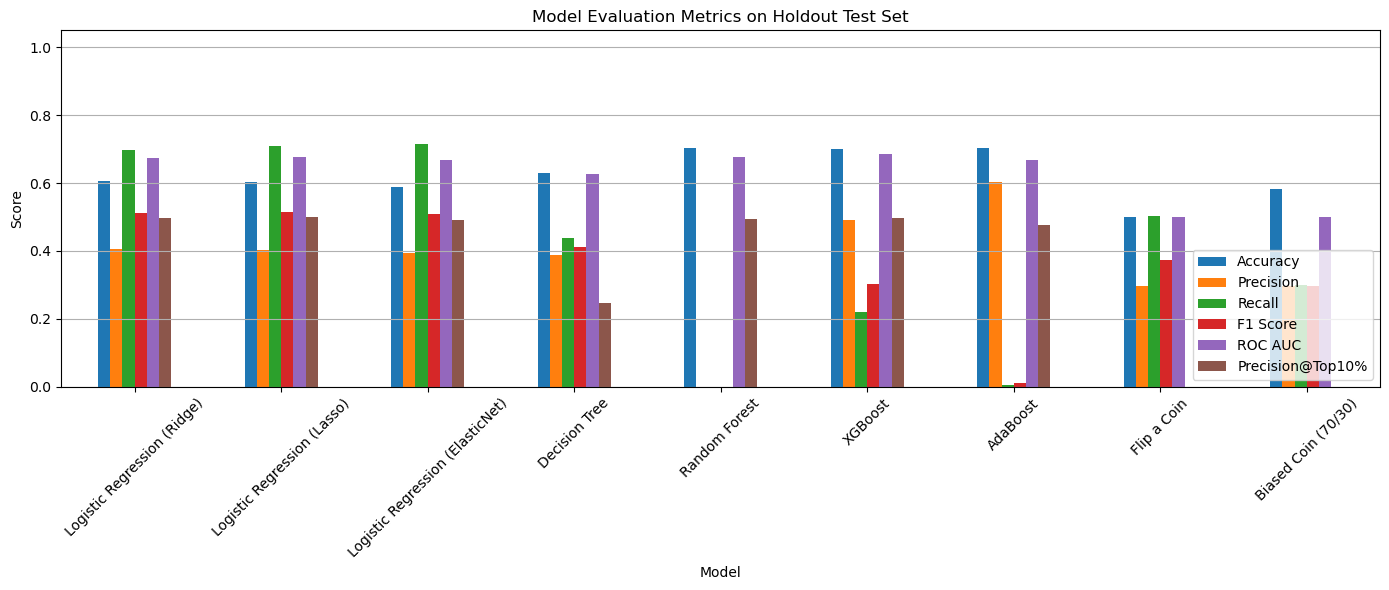

In [68]:
main_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Precision@Top10%']

results_df[main_metrics].plot(kind='bar', figsize=(14, 6), rot=45)
plt.title("Model Evaluation Metrics on Holdout Test Set")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### TP, FP, FN, TN Breakdown

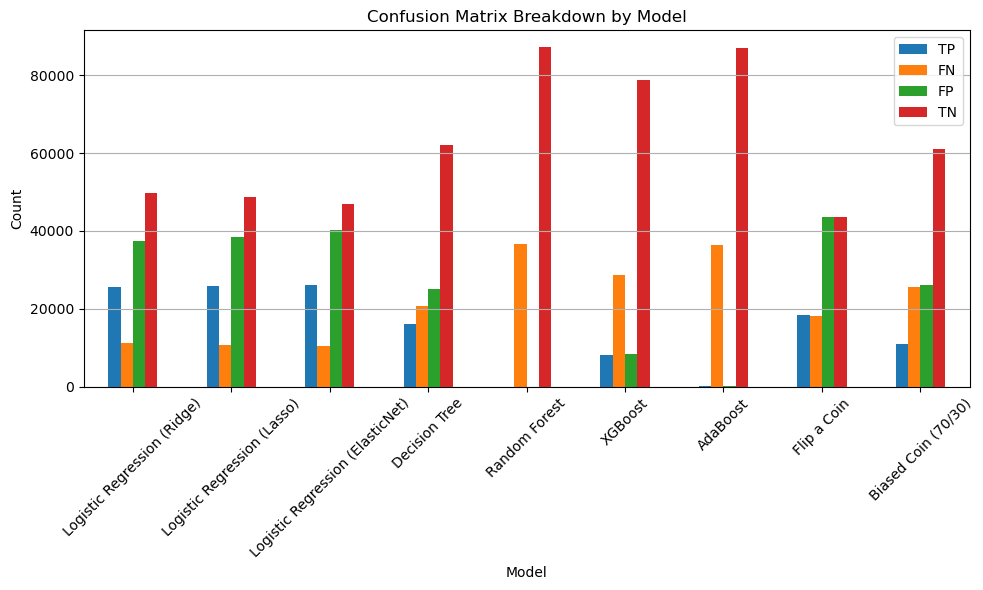

In [71]:
results_df[['TP', 'FN', 'FP', 'TN']].plot(kind='bar', figsize=(10, 6), rot=45)
plt.title("Confusion Matrix Breakdown by Model")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Projects Flagged for Expert Review

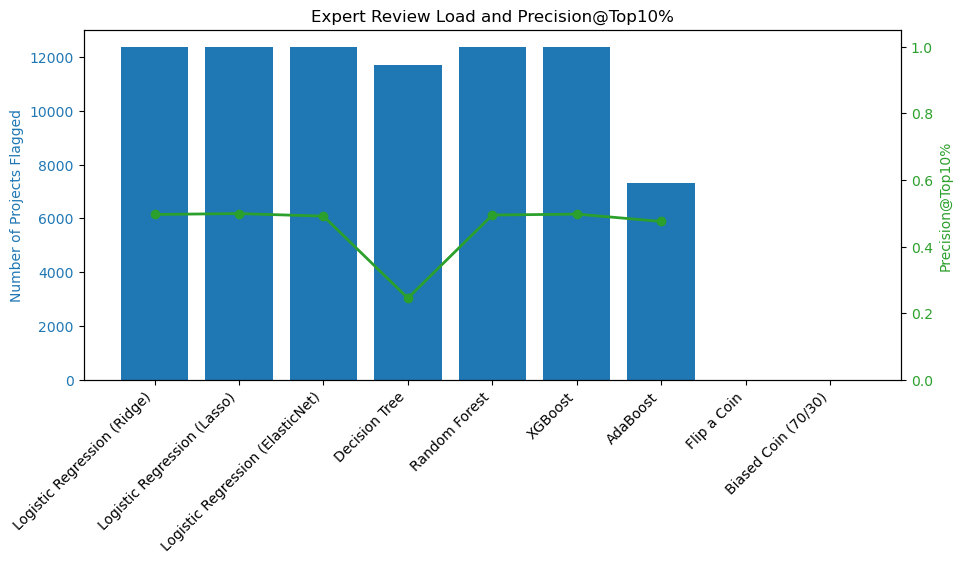

In [74]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
color2 = 'tab:green'

ax1.set_title("Expert Review Load and Precision@Top10%")
ax1.set_ylabel("Number of Projects Flagged", color=color1)
ax1.bar(results_df.index, results_df['num_Projects_flagged_for_review'], color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
ax2.set_ylabel("Precision@Top10%", color=color2)
ax2.plot(results_df.index, results_df['Precision@Top10%'], color=color2, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, 1.05)

# Explicit x-axis label rotation
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

fig.tight_layout(pad=2)
plt.show()

### Heatmap Summary of All Metrics

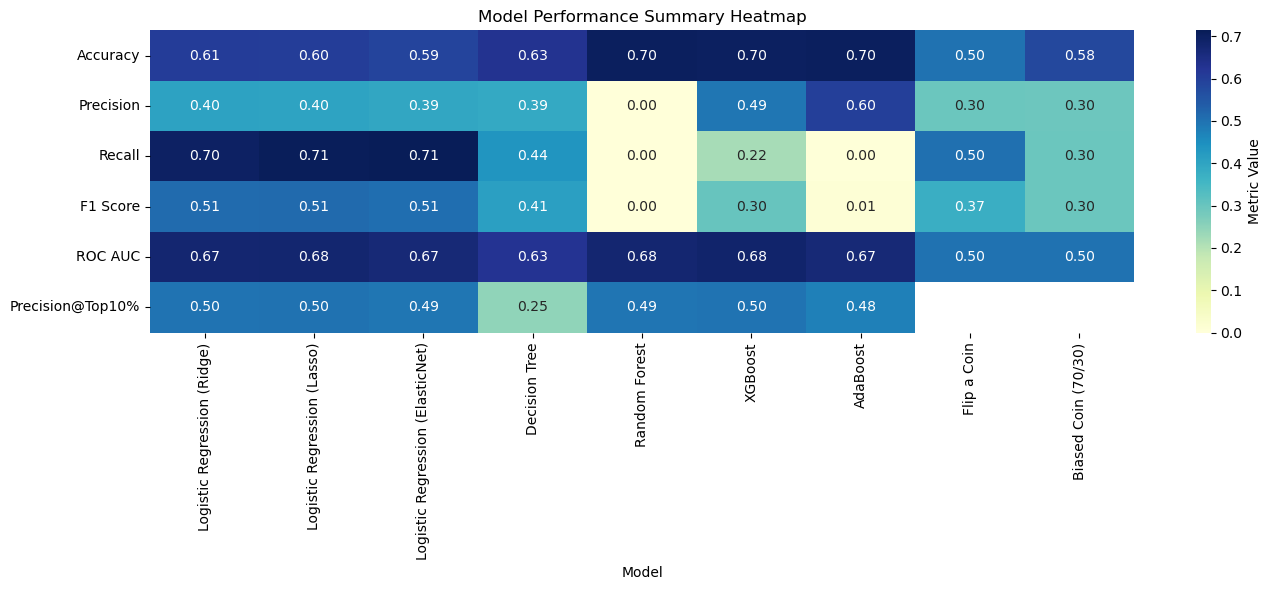

In [77]:
heatmap_metrics = main_metrics # + ['TP', 'FP', 'FN', 'num_Projects_flagged_for_review', 'fraction_Projects_flagged_for_review']

plt.figure(figsize=(14, 6))
sns.heatmap(results_df[heatmap_metrics].T, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Metric Value'})
plt.title("Model Performance Summary Heatmap")
plt.tight_layout()
plt.show()

### Final Metrics Summary Table

In [80]:
pd.set_option("display.precision", 3)

ordered_cols = [
    'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Precision@Top10%',
    'TP', 'FP', 'FN', 'TN',
    'num_Projects_flagged_for_review', 'fraction_Projects_flagged_for_review'
]

# Define highlighting logic
metrics_to_max = [
    'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC',
    'Precision@Top10%', 'TP', 'TN'
]

metrics_to_min = [
    'FP', 'FN'
]

styled = results_df[ordered_cols].style\
    .highlight_max(subset=metrics_to_max, color='lightgreen')\
    .highlight_min(subset=metrics_to_min, color='lightcoral')

display(styled)

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Precision@Top10%,TP,FP,FN,TN,num_Projects_flagged_for_review,fraction_Projects_flagged_for_review
Model,,,,,,,,,,,,
Logistic Regression (Ridge),0.607126,0.404712,0.695875,0.511780,0.674889,0.496688,25492,37496,11141,49669,12380,0.100002
Logistic Regression (Lasso),0.603580,0.403346,0.708733,0.514109,0.677718,0.499354,25963,38406,10670,48759,12380,0.100002
Logistic Regression (ElasticNet),0.589573,0.393369,0.713837,0.507225,0.667246,0.491599,26150,40327,10483,46838,12380,0.100002
Decision Tree,0.629841,0.388447,0.436874,0.411239,0.625816,0.245827,16004,25196,20629,61969,11683,0.094371
Random Forest,0.704091,0.000000,0.000000,0.000000,0.675322,0.494911,0,0,36633,87165,12380,0.100002
XGBoost,0.701667,0.490860,0.219911,0.303742,0.684726,0.497738,8056,8356,28577,78809,12380,0.100002
AdaBoost,0.704575,0.602041,0.004832,0.009586,0.668871,0.475768,177,117,36456,87048,7325,0.059169
Flip a Coin,0.500880,0.297405,0.504054,0.374088,0.500000,nan,18465,43622,18168,43543,0,0.000000
Biased Coin (70/30),0.581568,0.295171,0.298338,0.296746,0.500000,nan,10929,26097,25704,61068,0,0.000000


### Optional Threshold Evaluations (how well do we perfrom when we are X% certain?)

In [ ]:
'''
def evaluate_threshold(y_true, y_proba, threshold=0.5):
    print(f"\nEvaluating at threshold = {threshold:.2f}")
    y_pred = (y_proba >= threshold).astype(int)

    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    auc = roc_auc_score(y_true, y_proba)
    print(f"AUC: {auc:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

for thresh in [1, 0.99, 0.9, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05]:
    evaluate_threshold(y_test, y_proba, threshold=thresh)
'''